# Imports

In [1]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

from src.preprocessing import preprocess_data
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.save_model import save_model


# Load Data

In [2]:
X, y = preprocess_data(load_data())

# Model

## XGBoost Model

In [3]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [4]:
## Model
model = xgb.XGBClassifier(random_state=42, eval_metric="logloss")
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[
    :, 1
]  # Probability estimates for the positive class (default)

In [5]:
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

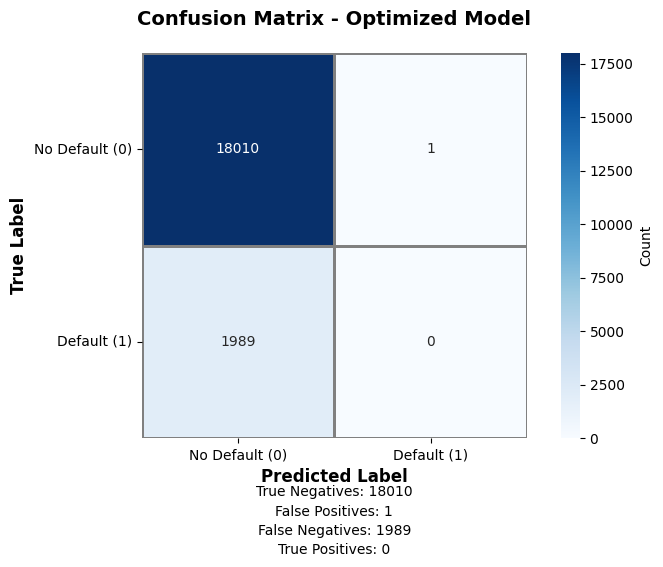


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [6]:
plot_confusion_matrix(y_test, y_pred, cmap="Blues")

## Hyperparameter fine-tuning (Optuna)

In [7]:
def objective(trial):
    # Suggest hyperparameters for XGBoost
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    subsample = trial.suggest_float("subsample", 0.4, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0.0, 1.0)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 1.0, 10.0)
    threshold = trial.suggest_float("threshold", 0.3, 0.9)

    # Create the model
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric="logloss",
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[
        :, 1
    ]  # Probability estimates for the positive class (default)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calculate F1-score (or any other metric you prefer)
    from sklearn.metrics import f1_score

    score = f1_score(y_test, y_pred)

    return score


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=500, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best F1-Score: {study.best_value:.4f}")
print("\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-15 22:53:21,802] A new study created in memory with name: no-name-ff198a4c-b689-4b06-9372-398b97ff92ba


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-10-15 22:53:24,283] Trial 0 finished with value: 0.07353608715388107 and parameters: {'n_estimators': 498, 'max_depth': 5, 'learning_rate': 0.04285298646810259, 'min_child_weight': 1, 'subsample': 0.6386865512495602, 'colsample_bytree': 0.8787654594600631, 'gamma': 0.32428121150539135, 'reg_alpha': 0.9149774458178094, 'reg_lambda': 0.9698882786347639, 'scale_pos_weight': 3.267513362455342, 'threshold': 0.6028032624804955}. Best is trial 0 with value: 0.07353608715388107.
[I 2025-10-15 22:53:25,309] Trial 1 finished with value: 0.06466512702078522 and parameters: {'n_estimators': 109, 'max_depth': 6, 'learning_rate': 0.12895475717038538, 'min_child_weight': 9, 'subsample': 0.6224505691727307, 'colsample_bytree': 0.9809400567645694, 'gamma': 0.5327569927107266, 'reg_alpha': 0.7239004963417406, 'reg_lambda': 0.6301842266604856, 'scale_pos_weight': 4.079391769079244, 'threshold': 0.6681529878206292}. Best is trial 0 with value: 0.07353608715388107.
[I 2025-10-15 22:53:26,325] Trial

In [8]:
# Train the final model with best parameters
best_params = study.best_params.copy()
threshold = best_params.pop("threshold")

model = xgb.XGBClassifier(**best_params, random_state=42, eval_metric="logloss")
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= threshold).astype(int)

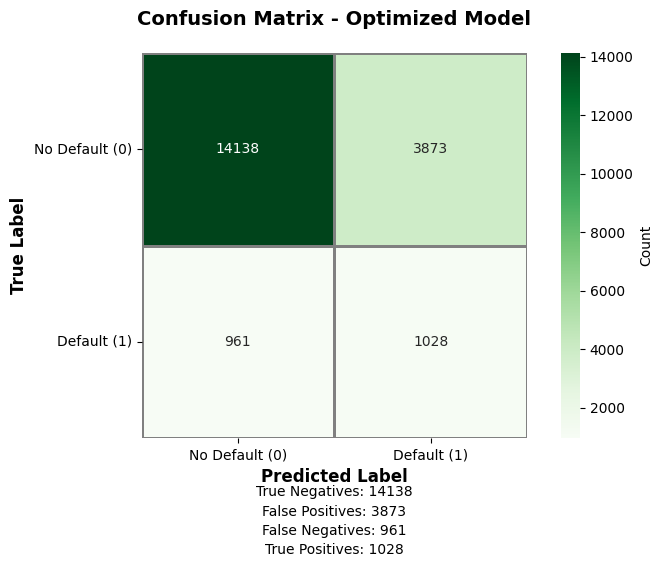


Model Metrics:
Accuracy:  0.7583 (75.83%)
Precision: 0.2098 (20.98%)
Recall:    0.5168 (51.68%)
F1-Score:  0.2984 (29.84%)


In [9]:
plot_confusion_matrix(y_test, y_pred, cmap="Greens")

In [10]:
compute_and_store_metrics(y_test, y_pred, model_name="XGBoost")

In [11]:
# Final training on the entire dataset
model = xgb.XGBClassifier(**best_params, eval_metric="logloss")
model.fit(X, y)
save_model(model, model_name="XGBoost")